In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from CommonTools.settings import SETTINGS
SETTINGS.SET_CREDENTIAL_INTERACTIVE()

from CommonTools.dbapi import ScotiaDB2, MySQL, dbIO
from CommonTools.login import get_credential
from CommonTools.remote import getMyRemote, MyRemote
from CommonTools.minio import MinIoAccessor

from sklearn import set_config

set_config(display = "diagram")

pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None) # default='warn'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [17]:
username, PASSWORD = get_credential()  # get SID and password

# remote servers
ip_iw607, port = "10.56.70.52", 22
iw607 = MyRemote(ip_iw607, port, username, PASSWORD)

Your SID:  ········
Your password:  ············


In [21]:
iw607.download('/rcca/ProdEcon/AQ/demo-loan-default/Loan_Default.csv', '/home/jovyan/work/Loan_Default.csv')
iw607.download('/rcca/ProdEcon/AQ/demo-loan-default/preprocessing_bank_loan.csv', '/home/jovyan/work/preprocessing_bank_loan.csv')

# EDA

In [9]:
from pandas_profiling import ProfileReport

profile = ProfileReport(pd.read_csv('/home/jovyan/work/Loan_Default.csv'), title = "EDA for bank loan")
profile.to_file("/home/jovyan/work/EDA_bank_loan.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Loading data

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('/home/jovyan/work/Loan_Default.csv').dropna(subset = ['Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'construction_type', 'business_or_commercial', 'Neg_ammortization', 'age', 'term', 'interest_only',  'lump_sum_payment', 'occupancy_type', 'Secured_by',
 'total_units', 'credit_type', 'co-applicant_credit_type', 'submission_of_application', 'Region', 'Security_Type', 'loan_amount'])

X = df.drop(columns = ['Status'])
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [3]:
df

ID  year loan_limit             Gender approv_in_adv loan_type  \
0        24890  2019         cf  Sex Not Available         nopre     type1   
1        24891  2019         cf               Male         nopre     type2   
2        24892  2019         cf               Male           pre     type1   
3        24893  2019         cf               Male         nopre     type1   
4        24894  2019         cf              Joint           pre     type1   
...        ...   ...        ...                ...           ...       ...   
148665  173555  2019         cf  Sex Not Available         nopre     type1   
148666  173556  2019         cf               Male         nopre     type1   
148667  173557  2019         cf               Male         nopre     type1   
148668  173558  2019         cf             Female         nopre     type1   
148669  173559  2019         cf             Female         nopre     type1   

       loan_purpose Credit_Worthiness open_credit business_or_commercial  \
0                p1                l1        nopc                  nob/c   
1                p1                l1        nopc                    b/c   
2                p1                l1        nopc                  nob/c   
3                p4                l1        nopc                  nob/c   
4                p1                l1        nopc                  nob/c   
...             ...               ...         ...                    ...   
148665           p3                l1        nopc                  nob/c   
148666           p1                l1        nopc                  nob/c   
148667           p4                l1        nopc                  nob/c   
148668           p4                l1        nopc                  nob/c   
148669           p3                l1        nopc                  nob/c   

        loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
0            116500               NaN                   NaN              NaN   
1            206500               NaN                   NaN              NaN   
2            406500             4.560                0.2000           595.00   
3            456500             4.250                0.6810              NaN   
4            696500             4.000                0.3042             0.00   
...             ...               ...                   ...              ...   
148665       436500             3.125                0.2571          9960.00   
148666       586500             5.190                0.8544             0.00   
148667       446500             3.125                0.0816          1226.64   
148668       196500             3.500                0.5824          4323.33   
148669       406500             4.375                1.3871          6000.00   

         term Neg_ammortization interest_only lump_sum_payment  \
0       360.0           not_neg       not_int         not_lpsm   
1       360.0           not_neg       not_int             lpsm   
2       360.0           neg_amm       not_int         not_lpsm   
3       360.0           not_neg       not_int         not_lpsm   
4       360.0           not_neg       not_int         not_lpsm   
...       ...               ...           ...              ...   
148665  180.0           not_neg       not_int         not_lpsm   
148666  360.0           not_neg       not_int         not_lpsm   
148667  180.0           not_neg       not_int         not_lpsm   
148668  180.0           not_neg       not_int         not_lpsm   
148669  240.0           not_neg       not_int         not_lpsm   

        property_value construction_type occupancy_type Secured_by  \
0             118000.0                sb             pr       home   
1                  NaN                sb             pr       home   
2             508000.0                sb             pr       home   
3             658000.0                sb             pr       home   
4             758000.0                sb             pr   

# Assembling pipelines

#### preliminary feature selection

In [4]:
from ModelingTools.FeatureEngineer.featureHelper import FeatureMeta
from ModelingTools.FeatureEngineer.transformers import PreliminaryFeatureSelector, FeaturePrescreen

fm = FeatureMeta(features_meta = pd.read_csv('/home/jovyan/work/preprocessing_bank_loan.csv'))
fp = FeaturePrescreen(feature_meta = fm, problem_type = 'classif',
                      add_id_policy_cols = ['ID', 'year', 'Interest_rate_spread', 'rate_of_interest'], threshold_missing = 0.25, 
                      threshold_variance_num = 0.05, threshold_variance_categ = 0.01, threshold_importance = "0.2*median", 
                      drop_ratio_score = 0.15, exec_sequence = "pmvu")

#### data preprocessing

##### Approach 1: build from scratch

In [5]:
from functools import partial

from sklearn import set_config

set_config(display = "diagram")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.binary import BinaryEncoder
from ModelingTools.FeatureEngineer.transformers import NamedTransformer, OutlierClipper
from ModelingTools.FeatureEngineer.utils import make_present_col_selector

In [6]:
preprocess_pipe = NamedTransformer(ColumnTransformer(
    transformers = [
        # categorical features
        (
            'loan_limit',
            Pipeline([
                ('imputer', NamedTransformer(SimpleImputer(strategy = "constant", fill_value = "missing"))),
                ('ohe', NamedTransformer(OneHotEncoder(categories = [('missing', 'cf', 'ncf')], sparse = False, drop = 'first')))
            ]),
            make_present_col_selector(['loan_limit'])
         ),
        ('Gender', NamedTransformer(OneHotEncoder(categories = [('Sex Not Available', 'Male', 'Female', 'Joint')], sparse = False, drop = 'first')), make_present_col_selector(['Gender'])),
        ('approv_in_adv', NamedTransformer(OneHotEncoder(categories = [['nopre', 'pre']], sparse = False, drop = "first")), make_present_col_selector(['approv_in_adv'])),
        ('loan_type', NamedTransformer(OneHotEncoder(sparse = False)), make_present_col_selector(['loan_type'])),
        ('loan_purpose', NamedTransformer(OneHotEncoder(sparse = False)), make_present_col_selector(['loan_purpose'])),
        ('Credit_Worthiness', OrdinalEncoder(mapping = [{'col' : 'Credit_Worthiness', 'mapping' : {'l1' : 0, 'l2' : 1}}], return_df = True, handle_unknown = 'value'), make_present_col_selector(['Credit_Worthiness'])),
        ('open_credit', NamedTransformer(OneHotEncoder(categories = [['nopc', 'opc']], sparse = False, drop = "first")), make_present_col_selector(['open_credit'])),
        ('business_or_commercial', NamedTransformer(OneHotEncoder(categories = [['nob/c', 'b/c']], sparse = False, drop = "first")), make_present_col_selector(['business_or_commercial'])),
        ('Neg_ammortization', NamedTransformer(OneHotEncoder(categories = [['not_neg', 'neg_amm']], sparse = False, drop = "first")), make_present_col_selector(['Neg_ammortization'])),
        ('interest_only', NamedTransformer(OneHotEncoder(categories = [['not_int', 'int_only']], sparse = False, drop = "first")), make_present_col_selector(['interest_only'])),
        ('lump_sum_payment', NamedTransformer(OneHotEncoder(categories = [['not_lpsm', 'lpsm']], sparse = False, drop = "first")), make_present_col_selector(['lump_sum_payment'])),
        ('construction_type', NamedTransformer(OneHotEncoder(sparse = False)), make_present_col_selector(['construction_type'])),
        ('occupancy_type', NamedTransformer(OneHotEncoder(sparse = False)), make_present_col_selector(['occupancy_type'])),
        ('Secured_by', NamedTransformer(OneHotEncoder(sparse = False)), make_present_col_selector(['Secured_by'])),
        (
            'total_units',
            Pipeline([
                ('mapper', OrdinalEncoder(mapping = [{'col' : 'total_units', 'mapping' : {'1U' : 1, '2U' : 2, '3U' : 3, '4U' : 4}}], return_df = True, handle_unknown = 'value')),
                ('scaler', NamedTransformer(MinMaxScaler(feature_range = (0.2, 1))))  # 4 intervals, 1/(1+4) = 0.2
            ]),
            make_present_col_selector(['total_units'])
         ),
        ('credit_type', NamedTransformer(OneHotEncoder(sparse = False)), make_present_col_selector(['credit_type'])),
        ('cact', NamedTransformer(OneHotEncoder(sparse = False)), make_present_col_selector(['co-applicant_credit_type'])),
        (
            'age',
            Pipeline([
                ('mapper', OrdinalEncoder(mapping = [{'col' : 'age', 'mapping' : {'<25' : 23, '25-34' : 30, '35-44' : 40, '45-54' : 50, '55-64' : 60, '65-74' : 70, '>74' : 80}}], return_df = True, handle_unknown = 'value')),
                ('scaler', NamedTransformer(MinMaxScaler(feature_range = (0.125, 1))))  # 7 intervals, 1/(1+7) = 0.125
            ]),
            make_present_col_selector(['age'])
         ),
        ('submission_of_application', NamedTransformer(OneHotEncoder(categories = [['not_inst', 'to_inst']], sparse = False, drop = "first")), make_present_col_selector(['submission_of_application'])),
        ('Region', NamedTransformer(OneHotEncoder(sparse = False)), make_present_col_selector(['Region'])),
        ('Security_Type', NamedTransformer(OneHotEncoder(categories = [['Indriect', 'direct']], sparse = False, drop = "first")), make_present_col_selector(['Security_Type'])),

        # numerical features
        (
            'loan_amount',
            Pipeline([
                ('log', NamedTransformer(FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate = True, accept_sparse = True))),
                ('scaler', NamedTransformer(RobustScaler()))  # robust to outliers
            ]),
            make_present_col_selector(['loan_amount'])
         ),
        (
            'Upfront_charges',
            Pipeline([
                ('impute', NamedTransformer(SimpleImputer(strategy = 'median', add_indicator = False))),  # add one more column to indicate missing value
                ('log', NamedTransformer(FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate = True, accept_sparse = True))),
                ('scaler', NamedTransformer(RobustScaler()))
            ]),
            make_present_col_selector(['Upfront_charges'])
        ),
        ('term', NamedTransformer(RobustScaler()), make_present_col_selector(['term'])),
        (
            'property_value',
            Pipeline([
                ('impute', NamedTransformer(SimpleImputer(strategy = 'median', add_indicator = False))),  # add one more column to indicate missing value
                ('log', NamedTransformer(FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate = True, accept_sparse = True))),
                ('scaler', NamedTransformer(RobustScaler()))
            ]),
            make_present_col_selector(['property_value'])
        ),
        (
            'income',
            Pipeline([
                ('impute', NamedTransformer(SimpleImputer(strategy = 'median', add_indicator = False))),  # add one more column to indicate missing value
                ('log', NamedTransformer(FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate = True, accept_sparse = True))),
                ('scaler', NamedTransformer(RobustScaler()))
            ]),
            make_present_col_selector(['income'])
        ),
        ('Credit_Score', NamedTransformer(RobustScaler()), make_present_col_selector(['Credit_Score'])),
        (
            'LTV',
            Pipeline([
                ('capper', OutlierClipper(strategy = 'constant', constant_capper = (0, 100))),  # clipping value to [0, 100], others are outliers
                ('impute', NamedTransformer(SimpleImputer(strategy = 'median', add_indicator = False))),  # add one more column to indicate missing value
                ('scaler', NamedTransformer(RobustScaler()))
            ]),
            make_present_col_selector(['LTV'])
        ),
        (
            'dtir1',
            Pipeline([
                ('impute', NamedTransformer(SimpleImputer(strategy = 'median', add_indicator = False))),  # add one more column to indicate missing value
                ('scaler', NamedTransformer(RobustScaler()))
            ]),
            make_present_col_selector(['dtir1'])
        ),
]))

In [7]:
#X_processed1 = preprocess_pipe.fit_transform(X_train)

##### Appproach 2: with the help of SimplePreprocessor

In [8]:
from ModelingTools.FeatureEngineer.transformers import *

# imputation
imputers = {}
for name, vtype, strategy, const in fm.iterfeature():
    imputers[name] = (strategy, const, False)
imph = ImputeHelper(imputers = imputers)

# categorcial features
ohe_encs = {
    # {'colname': (categories, drop, handle_unknown)}
    'loan_limit' : ([('missing', 'cf', 'ncf')], 'first', 'ignore'),
    'Gender' : ([('Sex Not Available', 'Male', 'Female', 'Joint')], 'first', 'ignore'),
    'approv_in_adv' : ([('nopre', 'pre')], 'first', 'ignore'),
    'loan_type' : ('auto', None, 'ignore'),
    'loan_purpose' : ('auto', None, 'ignore'),
    'open_credit' : ([('nopc', 'opc')], 'first', 'ignore'),
    'business_or_commercial' : ([('nob/c', 'b/c')], 'first', 'ignore'),
    'Neg_ammortization' : ([('not_neg', 'neg_amm')], 'first', 'ignore'),
    'interest_only' : ([('not_int', 'int_only')], 'first', 'ignore'),
    'lump_sum_payment' : ([('not_lpsm', 'lpsm')], 'first', 'ignore'),
    'construction_type' : ('auto', None, 'ignore'),
    'occupancy_type' : ('auto', None, 'ignore'),
    'Secured_by' : ('auto', None, 'ignore'),
    'credit_type' : ('auto', None, 'ignore'),
    'co-applicant_credit_type' : ('auto', None, 'ignore'),
    'submission_of_application' : ([('not_inst', 'to_inst')], 'first', 'ignore'),
    'Region' : ('auto', None, 'ignore'),
    'Security_Type' : ([('Indriect', 'direct')], 'first', 'ignore')
}
oheh = OnehotEncHelper(encs = ohe_encs)

ode_encs = {
    # after apply ordinal encoder, apply MinMaxScaler, so scale to (0,1) range
    'Credit_Worthiness': ({'l1' : 0, 'l2' : 1}, None, None), 
    'total_units' : ({'1U' : 0.2, '2U' : 0.467, '3U' : 0.733, '4U' : 1}, None, None),
    'age' : ({'<25' : 0.125, '25-34' : 0.232, '35-44' : 0.386, '45-54' : 0.539, '55-64' : 0.693, '65-74' : 0.846, '>74' : 1}, None, None)
}
odeh = OrdinalEncHelper(encs = ode_encs)

# numerical features
och = OutlierClipperHelper(clippers = {'LTV' : ('constant', None, (0, 100))})
sch = ScalerHelper(scalers = RobustScaler())
log_features = ['loan_amount', 'Upfront_charges', 'property_value', 'income']

    
preprocess_pipe = SimplePreprocessor(
    pre_drop = ['ID', 'year', 'Interest_rate_spread', 'rate_of_interest'],
    categorical_features = fm.getCategFeatures(), 
    imputers = imph,
    outlier_clippers = och, 
    log_features = log_features,
    scaler = sch, 
    onehot_encs = oheh, 
    ordinal_encs = odeh
)

In [11]:
#X_processed = preprocess_pipe.fit_transform(X_train)

In [28]:
#X_processed2.columns.difference(X_processed1.columns, sort = False)

In [10]:
#preprocess_pipe.preprocess_pipe_

NamedTransformer(transformer=Pipeline(steps=[('impute',
                                              NamedTransformer(transformer=ColumnTransformer(n_jobs=-1,
                                                                                             remainder='passthrough',
                                                                                             transformers=[('loan_limit',
                                                                                                            MyImputer(fill_value='missing',
                                                                                                                      strategy='constant'),
                                                                                                            functools.partial(<function _select_present_subset at 0x7f72cb1d74c0>, ['loan_limit'])),
                                                                                                           ('Gender',
                                                                                                            MyImputer(fill_value='missing',
                                                                                                                      strategy=...
                                                                                                            functools.partial(<function _select_present_subset at 0x7f72cb1d74c0>, Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'Neg_ammortization', 'interest_only', 'lump_sum_payment',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'credit_type', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'Region', 'Security_Type'],
      dtype='object')))])))]))

#### feature selection

In [11]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


feature_sel = NamedTransformer(SFS(estimator = BalancedRandomForestClassifier(n_estimators = 100), k_features = 24, forward = False, verbose = 2, scoring = 'roc_auc', cv = 3, n_jobs = -1))  # forward selection/backward elimination, use roc_auc as metrics
#feature_sel = NamedTransformer(RFE(estimator = RandomForestClassifier(n_estimators = 100), n_features_to_select = 0.8, verbose = 3))  # recursive feature elimination

#### Modeling Approach 1: SMOTE + GBDT

In [10]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from sklearn.ensemble import HistGradientBoostingClassifier

smote = SMOTE(k_neighbors = 5, n_jobs = -1)

gbdt = HistGradientBoostingClassifier(
    learning_rate = 0.1,
    max_leaf_nodes = 31,
    max_depth = None,
    l2_regularization = 0,
)

#### Modeling Approach 2: Balanced bagging + XGBoost (Used)

In [12]:
import xgboost
from imblearn.ensemble import BalancedBaggingClassifier

model = BalancedBaggingClassifier(
    base_estimator = xgboost.XGBClassifier(
        n_estimators = 100,
        max_depth = 8,
        max_leaves = 256,
        max_bin = 128,
        learning_rate = 0.05,
        objective = 'binary:logistic'
    ),
    n_estimators = 10,
    max_samples = 1.0,
    max_features = 1.0,
    n_jobs = -1
)

#### putting it together

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline 

# approach 1 param grid
param_grid = {
    'smote__k_neighbors' : [5, 8],
    'gbdt__learning_rate' : [0.1, 0.01],
    'gbdt__max_depth' : [None, 5],
    'gbdt__l2_regularization' : [0, 0.1]
}
# approach 2 param grid (used)
param_grid = {
    'max_features' : [1.0, 0.8],  # proportion of features selected for each bootstrap step of Bagging
    'base_estimator__max_depth' : [4, 6, 8],        # max depth of XGBoost
    'base_estimator__learning_rate' : [0.05, 0.01]  # learning rate of XGBoost
}

# https://stackoverflow.com/questions/43366561/use-sklearns-gridsearchcv-with-a-pipeline-preprocessing-just-once
base_pipe = Pipeline([
    ('preFeatureSel', fp),  # preliminary feature selection
    ('preprocess', preprocess_pipe),  # preprocessing pipeline
    ('feature_sel', feature_sel),  # backward feature elimination
    ('grid', GridSearchCV(
        estimator = model,
        param_grid = param_grid,
        scoring = ['balanced_accuracy', 'average_precision', 'roc_auc'],  # report three metrics
        refit = 'balanced_accuracy',  # use balanced accuracy as metric for best param choosing
        cv = StratifiedKFold(n_splits = 3),  # stratified sampling
        n_jobs = -1,
        verbose = 100
    ))
])

In [14]:
base_pipe.fit(X_train, y_train)

id_policy filter: 4 features eliminated (from 33 to 29)
Reduced features: ['ID', 'year', 'ID', 'year', 'Interest_rate_spread', 'rate_of_interest']
missing rate filter (threshold = 0.25): 1 features eliminated (from 29 to 28)
Reduced features: ['Upfront_charges']
Variance Threshold filter (threshold = Num: 0.05 | Categ: 0.01): 4 features eliminated (from 28 to 24), (Num 0 + Categ 4)
Reduced features: ['Secured_by', 'Security_Type', 'construction_type', 'open_credit']
Univariate (mutual information score) filter (drop percent = 15.0%, threshold = 0.0007360822720909321): 4 features eliminated (from 24 to 20)
Reduced features: ['Credit_Worthiness', 'interest_only', 'occupancy_type', 'total_units']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate b

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[04:56:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:56:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:56:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:56:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[CV 1/3; 2/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=0.8
[CV 1/3; 2/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=0.8; average_precision: (test=0.812) balanced_accuracy: (test=0.800) roc_auc: (test=0.877) total time= 2.1min
[CV 2/3; 2/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=0.8
[CV 2/3; 2/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=0.8; average_precision: (test=0.812) balanced_accuracy: (test=0.801) roc_auc: (test=0.876) total time= 2.2min


/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3; 1/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=1.0
[CV 1/3; 1/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=1.0; average_precision: (test=0.815) balanced_accuracy: (test=0.801) roc_auc: (test=0.877) total time= 2.1min
[CV 3/3; 2/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=0.8
[CV 3/3; 2/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=0.8; average_precision: (test=0.816) balanced_accuracy: (test=0.803) roc_auc: (test=0.878) total time= 2.2min


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0,

[CV 3/3; 1/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=1.0
[CV 3/3; 1/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=1.0; average_precision: (test=0.817) balanced_accuracy: (test=0.806) roc_auc: (test=0.877) total time= 2.1min
[CV 1/3; 3/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=1.0
[CV 1/3; 3/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=1.0; average_precision: (test=0.827) balanced_accuracy: (test=0.813) roc_auc: (test=0.886) total time= 3.5min


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0,

[CV 2/3; 1/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=1.0
[CV 2/3; 1/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=4, max_features=1.0; average_precision: (test=0.815) balanced_accuracy: (test=0.803) roc_auc: (test=0.877) total time= 2.1min
[CV 2/3; 3/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=1.0
[CV 2/3; 3/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=1.0; average_precision: (test=0.828) balanced_accuracy: (test=0.814) roc_auc: (test=0.886) total time= 3.6min


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0,

[CV 2/3; 4/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=0.8
[CV 2/3; 4/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=0.8; average_precision: (test=0.824) balanced_accuracy: (test=0.812) roc_auc: (test=0.885) total time= 3.2min
[CV 3/3; 5/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=1.0
[CV 3/3; 5/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=1.0; average_precision: (test=0.833) balanced_accuracy: (test=0.818) roc_auc: (test=0.889) total time= 5.1min
[CV 1/3; 7/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=1.0
[CV 1/3; 7/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=1.0; average_precision: (test=0.792) balanced_accuracy: (test=0.787) roc_auc: (test=0.861) total time= 2.2min


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[05:12:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric

[CV 3/3; 4/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=0.8
[CV 3/3; 4/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=0.8; average_precision: (test=0.826) balanced_accuracy: (test=0.814) roc_auc: (test=0.885) total time= 3.2min
[CV 1/3; 6/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=0.8
[CV 1/3; 6/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=0.8; average_precision: (test=0.829) balanced_accuracy: (test=0.816) roc_auc: (test=0.888) total time= 5.2min
[CV 2/3; 7/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=1.0
[CV 2/3; 7/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=1.0; average_precision: (test=0.790) balanced_accuracy: (test=0.787) roc_auc: (test=0.860) total time= 2.1min


[05:12:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:12:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:12:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:12:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[CV 1/3; 4/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=0.8
[CV 1/3; 4/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=0.8; average_precision: (test=0.822) balanced_accuracy: (test=0.808) roc_auc: (test=0.885) total time= 3.0min
[CV 1/3; 5/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=1.0
[CV 1/3; 5/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=1.0; average_precision: (test=0.831) balanced_accuracy: (test=0.817) roc_auc: (test=0.889) total time= 5.4min
[CV 2/3; 6/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=0.8
[CV 2/3; 6/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=0.8; average_precision: (test=0.829) balanced_accuracy: (test=0.814) roc_auc: (test=0.888) total time= 4.4min


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[05:13:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:34] WARNING: ../src/learner.cc:1115: St

[CV 3/3; 3/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=1.0
[CV 3/3; 3/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=6, max_features=1.0; average_precision: (test=0.829) balanced_accuracy: (test=0.815) roc_auc: (test=0.885) total time= 3.2min
[CV 2/3; 5/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=1.0
[CV 2/3; 5/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=1.0; average_precision: (test=0.831) balanced_accuracy: (test=0.817) roc_auc: (test=0.889) total time= 5.4min
[CV 3/3; 6/12] START base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=0.8
[CV 3/3; 6/12] END base_estimator__learning_rate=0.05, base_estimator__max_depth=8, max_features=0.8; average_precision: (test=0.828) balanced_accuracy: (test=0.816) roc_auc: (test=0.887) total time= 4.7min


[05:13:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[CV 1/3; 8/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=0.8
[CV 1/3; 8/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=0.8; average_precision: (test=0.794) balanced_accuracy: (test=0.787) roc_auc: (test=0.862) total time= 1.6min
[CV 2/3; 9/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=1.0
[CV 2/3; 9/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=1.0; average_precision: (test=0.806) balanced_accuracy: (test=0.798) roc_auc: (test=0.871) total time= 3.6min
[CV 3/3; 10/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=0.8
[CV 3/3; 10/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=0.8; average_precision: (test=0.808) balanced_accuracy: (test=0.797) roc_auc: (test=0.871) total time= 3.1min


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 7/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=1.0
[CV 3/3; 7/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=1.0; average_precision: (test=0.794) balanced_accuracy: (test=0.788) roc_auc: (test=0.862) total time= 1.6min
[CV 1/3; 9/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=1.0
[CV 1/3; 9/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=1.0; average_precision: (test=0.806) balanced_accuracy: (test=0.797) roc_auc: (test=0.871) total time= 3.7min
[CV 2/3; 10/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=0.8
[CV 2/3; 10/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=0.8; average_precision: (test=0.811) balanced_accuracy: (test=0.797) roc_auc: (test=0.874) total time= 3.2min


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[CV 2/3; 8/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=0.8
[CV 2/3; 8/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=0.8; average_precision: (test=0.791) balanced_accuracy: (test=0.777) roc_auc: (test=0.862) total time= 2.1min
[CV 3/3; 9/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=1.0
[CV 3/3; 9/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=1.0; average_precision: (test=0.808) balanced_accuracy: (test=0.798) roc_auc: (test=0.871) total time= 3.5min
[CV 1/3; 11/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=8, max_features=1.0
[CV 1/3; 11/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=8, max_features=1.0; average_precision: (test=0.816) balanced_accuracy: (test=0.807) roc_auc: (test=0.878) total time= 5.5min


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[CV 3/3; 8/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=0.8
[CV 3/3; 8/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=4, max_features=0.8; average_precision: (test=0.796) balanced_accuracy: (test=0.786) roc_auc: (test=0.863) total time= 2.1min
[CV 1/3; 10/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=0.8
[CV 1/3; 10/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=6, max_features=0.8; average_precision: (test=0.808) balanced_accuracy: (test=0.798) roc_auc: (test=0.872) total time= 3.4min
[CV 2/3; 11/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=8, max_features=1.0
[CV 2/3; 11/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=8, max_features=1.0; average_precision: (test=0.817) balanced_accuracy: (test=0.806) roc_auc: (test=0.878) total time= 5.5min


[05:24:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:24:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:24:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:25:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[CV 2/3; 12/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=8, max_features=0.8
[CV 2/3; 12/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=8, max_features=0.8; average_precision: (test=0.817) balanced_accuracy: (test=0.802) roc_auc: (test=0.879) total time= 2.8min
[05:28:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:04:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0,

[CV 3/3; 12/12] START base_estimator__learning_rate=0.01, base_estimator__max_depth=8, max_features=0.8
[CV 3/3; 12/12] END base_estimator__learning_rate=0.01, base_estimator__max_depth=8, max_features=0.8; average_precision: (test=0.820) balanced_accuracy: (test=0.810) roc_auc: (test=0.881) total time= 2.6min
[05:28:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:05:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0,

Pipeline(steps=[('preFeatureSel',
                 FeaturePrescreen(add_id_policy_cols=['ID', 'year',
                                                      'Interest_rate_spread',
                                                      'rate_of_interest'],
                                  drop_ratio_score=0.15, exec_sequence='pmvu',
                                  feature_meta=<ModelingTools.FeatureEngineer.featureHelper.FeatureMeta object at 0x7f5ace8e8820>,
                                  threshold_importance='0.2*median',
                                  threshold_variance_categ=0.01,
                                  threshold_variance_num=0....
                                                                                               reg_lambda=None,
                                                                                               scale_pos_weight=None,
                                                                                               subsample=None,
                                                                                               tree_method=None,
                                                                                               validate_parameters=None,
                                                                                               verbosity=None),
                                                                  n_jobs=-1),
                              n_jobs=-1,
                              param_grid={'base_estimator__learning_rate': [0.05,
                                                                            0.01],
                                          'base_estimator__max_depth': [4, 6,
                                                                        8],
                                          'max_features': [1.0, 0.8]},
                              refit='balanced_accuracy',
                              scoring=['balanced_accuracy', 'average_precision',
                                       'roc_auc'],
                              verbose=100))])

In [15]:
from joblib import dump, load

dump(base_pipe, '/home/jovyan/work/loan_default_bagging_xgboost.joblib')

['/home/jovyan/work/loan_default_bagging_xgboost.joblib']

In [18]:
iw607.upload('/home/jovyan/work/loan_default_bagging_xgboost.joblib', '/rcca/ProdEcon/AQ/demo-loan-default/loan_default_bagging_xgboost.joblib')

# Parameters Overview

In [35]:
from joblib import dump, load

# iw607.download('/rcca/ProdEcon/AQ/demo-loan-default/loan_default_smote_gbdt.joblib', '/home/jovyan/work/loan_default_smote_gbdt.joblib')
base_pipe_r = load('/home/jovyan/work/loan_default_bagging_xgboost.joblib')

In [36]:
base_pipe_r['preFeatureSel'].get_report(summarize = False)

Step Pre# Post# Drop#     Drop%        Metric  \
0                IdPolicy   33    29     4  0.121212           NaN   
1          Missing Values   29    28     1  0.034483  Missing Rate   
2      Variance Threshold   28    24     4  0.142857      Variance   
3  Univaraite Correlation   24    20     4  0.166667   Mutual Info   

      Threshold                                        RemovedCols  
0           NaN  [ID, year, ID, year, Interest_rate_spread, rat...  
1          0.25                                  [Upfront_charges]  
2  (0.05, 0.01)  [Secured_by, Security_Type, construction_type,...  
3      0.000736  [Credit_Worthiness, interest_only, occupancy_t...

In [37]:
# backward feature elimination cv results
selector = base_pipe_r['feature_sel'].transformer
cv_results_ = pd.DataFrame.from_dict(selector.get_metric_dict(confidence_interval = 0.95)).T
cv_results_[['avg_score', 'std_dev', 'ci_bound', 'std_err']] = cv_results_[['avg_score', 'std_dev', 'ci_bound', 'std_err']].astype('float32')
cv_results_['safe_score'] = cv_results_['avg_score'] - cv_results_['ci_bound'].fillna(0)
cv_results_

feature_idx  \
35  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
34  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...   
33  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...   
32  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...   
31  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...   
30  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...   
29  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15,...   
28  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16,...   
27  (0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 15, 16, 17...   
26  (0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 15, 16, 17, 1...   
25  (0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 15, 16, 18, 1...   
24  (0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 15, 16, 18, 1...   

                                            cv_scores  avg_score  \
35  [0.8836110806406172, 0.880336770405039, 0.8817...   0.881891   
34  [0.8842809919595722, 0.8805040726792025, 0.882...   0.882540   
33  [0.8841824321702291, 0.8818412037568227, 0.883...   0.883303   
32  [0.8858798295557627, 0.8822969460299608, 0.883...   0.883949   
31  [0.8861949977816079, 0.8825322465383767, 0.883...   0.884085   
30  [0.8852261201338796, 0.8832145667032734, 0.884...   0.884316   
29  [0.8857866458822875, 0.8839326949519708, 0.884...   0.884729   
28  [0.8868425237946539, 0.8840670278015587, 0.883...   0.884822   
27  [0.8867051946798378, 0.8841413075106055, 0.884...   0.884965   
26  [0.8854660507564177, 0.8845329269059785, 0.884...   0.884761   
25  [0.885840266946743, 0.8843687277188892, 0.8838...   0.884702   
24  [0.8853563026920647, 0.8841862252213593, 0.883...   0.884504   

                                        feature_names  ci_bound   std_dev  \
35  (loan_amount, property_value, income, LTV, ter...  0.003020  0.001342   
34  (loan_amount, property_value, income, LTV, ter...  0.003501  0.001556   
33  (loan_amount, property_value, income, LTV, ter...  0.002342  0.001041   
32  (loan_amount, property_value, income, LTV, ter...  0.003321  0.001476   
31  (loan_amount, property_value, income, LTV, ter...  0.003480  0.001546   
30  (loan_amount, property_value, income, LTV, ter...  0.001873  0.000832   
29  (loan_amount, property_value, income, LTV, ter...  0.001753  0.000779   
28  (loan_amount, property_value, income, LTV, ter...  0.003250  0.001444   
27  (loan_amount, property_value, income, LTV, ter...  0.002771  0.001231   
26  (loan_amount, property_value, income, LTV, ter...  0.001144  0.000508   
25  (loan_amount, property_value, income, LTV, ter...  0.001863  0.000828   
24  (loan_amount, property_value, income, LTV, ter...  0.001371  0.000609   

     std_err  safe_score  
35  0.000949    0.878871  
34  0.001100    0.879039  
33  0.000736    0.880961  
32  0.001044    0.880628  
31  0.001093    0.880605  
30  0.000589    0.882443  
29  0.000551    0.882976  
28  0.001021    0.881572  
27  0.000871    0.882194  
26  0.000360    0.883617  
25  0.000585    0.882839  
24  0.000431    0.883132

In [38]:
base_pipe_r['grid'].best_params_

{'base_estimator__learning_rate': 0.05,
 'base_estimator__max_depth': 8,
 'max_features': 1.0}

In [39]:
pd.DataFrame(base_pipe_r['grid'].cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      125.492330      0.496227         2.769255        0.280623   
1      126.445483      3.682987         2.679467        0.328226   
2      201.832953     10.161133         3.937626        0.094041   
3      181.990518      5.386180         3.938622        0.093601   
4      312.828918      8.860970         4.506052        0.292761   
5      280.228338     18.494483         4.705878        0.615033   
6      115.340356     17.313092         2.531728        0.398357   
7      112.756228     13.039552         3.136113        0.049937   
8      212.136565      6.278099         3.871456        0.040742   
9      190.605538      5.742325         3.666695        0.044191   
10     319.202815      7.039476         4.865441        0.233278   
11     206.387601     67.514429         2.676868        1.497733   

   param_base_estimator__learning_rate param_base_estimator__max_depth  \
0                                 0.05                               4   
1                                 0.05                               4   
2                                 0.05                               6   
3                                 0.05                               6   
4                                 0.05                               8   
5                                 0.05                               8   
6                                 0.01                               4   
7                                 0.01                               4   
8                                 0.01                               6   
9                                 0.01                               6   
10                                0.01                               8   
11                                0.01                               8   

   param_max_features                                             params  \
0                 1.0  {'base_estimator__learning_rate': 0.05, 'base_...   
1                 0.8  {'base_estimator__learning_rate': 0.05, 'base_...   
2                 1.0  {'base_estimator__learning_rate': 0.05, 'base_...   
3                 0.8  {'base_estimator__learning_rate': 0.05, 'base_...   
4                 1.0  {'base_estimator__learning_rate': 0.05, 'base_...   
5                 0.8  {'base_estimator__learning_rate': 0.05, 'base_...   
6                 1.0  {'base_estimator__learning_rate': 0.01, 'base_...   
7                 0.8  {'base_estimator__learning_rate': 0.01, 'base_...   
8                 1.0  {'base_estimator__learning_rate': 0.01, 'base_...   
9                 0.8  {'base_estimator__learning_rate': 0.01, 'base_...   
10                1.0  {'base_estimator__learning_rate': 0.01, 'base_...   
11                0.8  {'base_estimator__learning_rate': 0.01, 'base_...   

    split0_test_balanced_accuracy  split1_test_balanced_accuracy  \
0                        0.801041                       0.803057   
1                        0.799899                       0.801403   
2                        0.813244                       0.814236   
3                        0.808024                       0.811507   
4                        0.816818                       0.817225   
5                        0.816194                       0.814134   
6                        0.786754                       0.786718   
7                        0.787007                       0.777469   
8                        0.797214                       0.797536   
9                        0.797808                       0.796845   
10                       0.806780                       0.806440   
11                       0.805834                       0.801545   

    split2_test_balanced_accuracy  mean_test_balanced_accuracy  \
0                        0.806103                     0.803400   
1                        0.803326                     0.801542   
2                        0.814858                     0.814113   
3                 

# Model Validation

In [27]:
from imblearn.metrics import classification_report_imbalanced

y_pred = base_pipe_r.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.93      0.70      0.92      0.81      0.67     22230
          1       0.77      0.70      0.93      0.73      0.81      0.64      7225

avg / total       0.87      0.88      0.75      0.87      0.81      0.66     29455



In [28]:
%matplotlib inline

In [29]:
from ModelingTools.Evaluation import ClfValidator

clv = ClfValidator(base_pipe_r, X_test, y_test)

In [35]:
clv.confusion_matrix()

Predicted      0     1
Actual                
0          21183  1047
1           2309  4916

{0:       threshold       fpr       tpr
 0      1.952489  0.000000  0.000000
 1      0.952489  0.000000  0.000045
 2      0.924520  0.000000  0.000540
 3      0.924082  0.000138  0.000540
 4      0.906504  0.000138  0.008187
 ...         ...       ...       ...
 5188   0.016062  0.585052  0.999910
 5189   0.014291  0.587266  0.999910
 5190   0.014124  0.587266  0.999955
 5191   0.004727  0.592664  0.999955
 5192   0.003392  1.000000  1.000000
 
 [5193 rows x 3 columns],
 1:       threshold       fpr       tpr
 0      1.996608  0.000000  0.000000
 1      0.996608  0.000045  0.407336
 2      0.985897  0.000045  0.412734
 3      0.985876  0.000090  0.412734
 4      0.983951  0.000090  0.414948
 ...         ...       ...       ...
 5179   0.093543  0.991813  0.999723
 5180   0.093527  0.991813  0.999862
 5181   0.076909  0.999460  0.999862
 5182   0.075918  0.999460  1.000000
 5183   0.047511  1.000000  1.000000
 
 [5184 rows x 3 columns]}

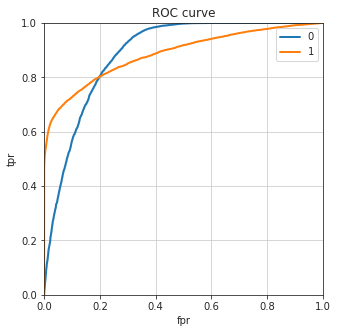

In [30]:
clv.roc_curve()

{0:        threshold  precision    recall
 0       0.003392   0.754711  1.000000
 1       0.004727   0.838482  0.999955
 2       0.005411   0.838514  0.999955
 3       0.006677   0.838545  0.999955
 4       0.007775   0.838577  0.999955
 ...          ...        ...       ...
 26500   0.936739   1.000000  0.000225
 26501   0.937403   1.000000  0.000180
 26502   0.941052   1.000000  0.000135
 26503   0.950129   1.000000  0.000090
 26504   0.952489   1.000000  0.000045
 
 [26505 rows x 3 columns],
 1:        threshold  precision    recall
 0       0.075918   0.245389  1.000000
 1       0.076909   0.245364  0.999862
 2       0.077751   0.245372  0.999862
 3       0.078997   0.245380  0.999862
 4       0.079126   0.245389  0.999862
 ...          ...        ...       ...
 26492   0.992225   0.999661  0.407889
 26493   0.993323   0.999661  0.407751
 26494   0.994589   0.999661  0.407612
 26495   0.995273   0.999660  0.407474
 26496   0.996608   0.999660  0.407336
 
 [26497 rows x 3 columns]}

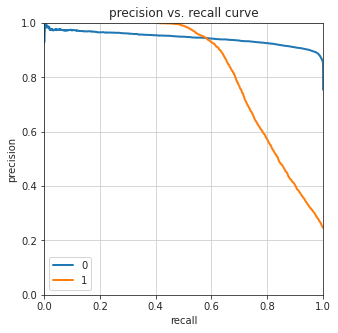

In [31]:
clv.precision_recall()